# Load Library

In [1]:
# general imports
import sys
import os
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import multiprocessing as mp
import wandb
from tqdm import tqdm
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split 
from base.dgd.nn import NB_Module
from base.dgd.DGD import DGD
from base.utils.helpers import set_seed, get_activation
from base.model.decoder import Decoder
from base.data.combined import GeneExpressionDatasetCombined
from base.engine.train import train_midgd
from base.dgd.latent import RepresentationLayer
from base.engine.predict import learn_new_representation #, learn_new_representation_mrna
from base.plotting.plot_cv2 import plot_latent_space, plot_gene, plot_mirna
from sklearn.metrics import root_mean_squared_error

In [2]:
# set random seeds, device and data directory
seed = 42
set_seed(seed)

num_workers = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load Data

In [3]:
tcga_mrna_raw = pd.read_table("data/TCGA_mrna_counts_match_iso.tsv", sep='\t', index_col=[0])
tcga_mirna_raw = pd.read_table("data/TCGA_mirna_counts_match_iso.tsv", sep='\t', index_col=[0])
sample_annot = pd.read_table("data/TCGA_sample_anno_iso_match.tsv", sep='\t', index_col=[0])
mirna_annot = pd.read_table("data/TCGA_mirna_anno_iso_match.tsv", sep='\t', index_col=[0])

In [4]:
def filter_sample_type(df):
    return df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal', 'Primary Blood Derived Cancer - Peripheral Blood'])]

filtered_annot = filter_sample_type(sample_annot)

filtered_annot.groupby('sample_type')['sample_id'].nunique()

sample_type
Primary Blood Derived Cancer - Peripheral Blood     173
Primary Tumor                                      9458
Solid Tissue Normal                                 619
Name: sample_id, dtype: int64

In [ ]:
def data_filtering(df, filter_zero=True, filter_tumor=True, filter_type=False):
    if filter_zero:
        zero_counts = (df == 0).mean()
        selected_features = zero_counts[zero_counts < 0.99].index
        df = df[selected_features]
    if filter_tumor:
        df = df[df['sample_type'].isin(['Primary Tumor', 'Solid Tissue Normal', 'Primary Blood Derived Cancer - Peripheral Blood'])]
    if filter_type:
        count = df['cancer_type'].value_counts().reset_index()
        keep = count[count['sample_id'] > 100]['cancer_type']
        df = df[df['cancer_type'].isin(keep)]
    return df

# make data split for train, validation, and test sets
train_ratio= 0.7
# Train, val, and test data loaders
batch_size = 128

# Filter data
tcga_mrna = data_filtering(tcga_mrna_raw)
tcga_mirna = data_filtering(tcga_mirna_raw)

# Shuffle the data
tcga_mrna = tcga_mrna.sample(frac=1, random_state=seed)
tcga_mirna = tcga_mirna.sample(frac=1, random_state=seed)

# color mapping
color_mapping = dict(zip(tcga_mrna['cancer_type'], tcga_mrna['color']))

train_mrna, val_mrna = train_test_split(tcga_mrna, train_size=train_ratio, stratify=tcga_mrna['cancer_type'], random_state=seed) 
val_mrna, test_mrna = train_test_split(val_mrna, test_size=0.50, stratify=val_mrna['cancer_type'], random_state=seed)

# Get the indices of the samples in each split
train_idx = train_mrna.index
val_idx = val_mrna.index
test_idx = test_mrna.index

# Use the same indices to split tcga_mirna
train_mirna = tcga_mirna.loc[train_idx]
val_mirna = tcga_mirna.loc[val_idx]
test_mirna = tcga_mirna.loc[test_idx]

# Default scaling_type = "mean"
train_dataset = GeneExpressionDatasetCombined(train_mrna, train_mirna, scaling_type='mean')
validation_dataset = GeneExpressionDatasetCombined(val_mrna, val_mirna, scaling_type='mean')
test_dataset = GeneExpressionDatasetCombined(test_mrna, test_mirna, scaling_type='mean')

train_loader = torch.utils.data.DataLoader(train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True,
                                           num_workers=num_workers)
validation_loader = torch.utils.data.DataLoader(validation_dataset, 
                                                batch_size=batch_size, 
                                                shuffle=False,
                                                num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False,
                                          num_workers=num_workers)

data_loader = train_loader, validation_loader, test_loader

In [6]:
# make data split for train and validation sets
mrna_out_dim = train_mrna.shape[1]-4
mirna_out_dim = train_mirna.shape[1]-4

print(tcga_mrna.shape)
print(tcga_mirna.shape)
print(mrna_out_dim)
print(mirna_out_dim)

(10250, 19745)
(10250, 2028)
19741
2024


In [7]:
# Change column name
mirna_column = pd.Series(train_mirna.columns[:-4])

# Convert mirna_annot DataFrame to a dictionary for mapping
mapping_dict = dict(zip(mirna_annot['mature_iso_id'], mirna_annot['mature_iso_name_miRBase']))

# Replace the values in mirna_column using the mapping dictionary
mirna_column = mirna_column.map(mapping_dict).fillna(mirna_column)
mirna_column = np.array(mirna_column)

print(mirna_column)

['hsa-let-7a-5p' 'hsa-let-7a-2-3p' 'hsa-let-7b-5p' ... 'hsa-miR-3168'
 'hsa-miR-3119' 'hsa-miR-6823-3p']


In [8]:
palette = dict(zip(train_mirna['cancer_type'], train_mirna['color']))
print(palette)

{'LGG': '#D49DC6', 'HNSC': '#97D1A9', 'BLCA': '#F9D2DB', 'OV': '#DA7D27', 'PRAD': '#7F1717', 'CESC': '#F7B666', 'MESO': '#542C88', 'KIRC': '#F8AEB2', 'COAD': '#9EDCF8', 'BRCA': '#ED1E91', 'UCEC': '#FBE3C7', 'KIRP': '#EB6F76', 'THCA': '#F4ED2F', 'LUSC': '#A084BD', 'LAML': '#744C27', 'LIHC': '#CACDDD', 'ACC': '#CCAB8E', 'SARC': '#00A99D', 'LUAD': '#D2C3DF', 'ESCA': '#007DB4', 'READ': '#DAF1FC', 'PCPG': '#E7C41D', 'TGCT': '#BE1D2C', 'UVM': '#0D9344', 'STAD': '#00AEEF', 'SKCM': '#BAD543', 'PAAD': '#6E7BA3', 'THYM': '#CCAB8E', 'CHOL': '#104A7F', 'KICH': '#EE1D23', 'DLBC': '#3953A4', 'UCS': '#F79420'}


# Load Model

In [9]:
dgd = torch.load('models/midgd-ms-filtered-best.pth')

In [10]:
new_rep = learn_new_representation(dgd, test_loader, learning_rates=1e-2, weight_decay=0., test_epochs=50)
dgd.test_rep = new_rep

100%|███████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:44<00:00,  1.13it/s]


In [11]:
dgd

DGD(
  (decoder): Decoder(
    (main): ModuleList(
      (0): Linear(in_features=22, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=100, bias=True)
      (5): ReLU()
    )
    (out_module_mirna): ZINB_Module(
      (fc): Sequential(
        (0): Linear(in_features=100, out_features=100, bias=True)
        (1): ReLU()
        (2): Linear(in_features=100, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=2024, bias=True)
      )
    )
    (out_module_mrna): NB_Module(
      (fc): Sequential(
        (0): Linear(in_features=100, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=256, bias=True)
        (3): ReLU()
        (4): Linear(in_features=256, out_features=19741, bias=True)
      )
    )
  )
  (gmm): GaussianMixture()
  (train_rep): RepresentationLayer()
  (v

## generate analysis data

In [12]:
def _add_columns(X, y, data_loader):
    X = X.assign(tissue=data_loader.dataset.tissue_type)
    X = X.assign(sample=data_loader.dataset.sample_type)
    X = X.assign(color=data_loader.dataset.color)
    X = X.assign(cancer_type=data_loader.dataset.label)
    
    y = y.assign(tissue=data_loader.dataset.tissue_type)
    y = y.assign(sample=data_loader.dataset.sample_type)
    y = y.assign(color=data_loader.dataset.color)
    y = y.assign(cancer_type=data_loader.dataset.label)
    return X, y

def _get_data_prediction(dgd, data_loader, mirna_column_name, dataset="train"):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        if dataset == "train":
            X, _ = dgd.forward(dgd.train_rep()) 
        elif dataset == "val":
            X, _ = dgd.forward(dgd.val_rep()) 
        elif dataset == "test":
            X, _ = dgd.forward(dgd.test_rep()) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y

def _get_data_pred_from_rep(dgd, test_rep, data_loader, mirna_column_name):
    with torch.inference_mode():
        scaling = torch.mean(data_loader.dataset.mirna_data, axis=1)
        X, _ = dgd.forward(test_rep.z) 
        X = X * scaling.unsqueeze(1).to(device)
        X = X.detach().cpu().numpy()
        X = pd.DataFrame(X, columns=mirna_column_name)

        y = data_loader.dataset.mirna_data
        y = y.detach().cpu().numpy()
        y = pd.DataFrame(y, columns=mirna_column_name)
        
        X, y = _add_columns(X, y, data_loader)
    return X, y
    
def generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column_name, subset=False, dataset="test"):
    if subset:
        if dataset == "train":
            X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
            train = pd.DataFrame(
                data={
                    'X': X_train[subset], 
                    'y': y_train[subset],
                    'cancer_type': train_loader.dataset.label,
                    'tissue': train_loader.dataset.tissue_type,
                    'color': train_loader.dataset.color
                }
            )
            return train
        elif dataset == "val":
            X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
            val = pd.DataFrame(
                data={
                    'X': X_val[subset], 
                    'y': y_val[subset],
                    'cancer_type': validation_loader.dataset.label,
                    'tissue': validation_loader.dataset.tissue_type,
                    'color': validation_loader.dataset.color
                }
            )
            return val
        elif dataset == "test":
            X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
            test = pd.DataFrame(
                data={
                    'X': X_test[subset], 
                    'y': y_test[subset],
                    'cancer_type': test_loader.dataset.label,
                    'tissue': test_loader.dataset.tissue_type,
                    'color': test_loader.dataset.color
                }
            )
            return test
    else:
        X_train, y_train = _get_data_prediction(dgd, train_loader, mirna_column_name, dataset="train")
        X_val, y_val = _get_data_prediction(dgd, validation_loader, mirna_column_name, dataset="val")
        X_test, y_test = _get_data_prediction(dgd, test_loader, mirna_column_name, dataset="test")
        
    return X_train, y_train, X_val, y_val, X_test, y_test

def get_mirna_data(dgd, data_loader, subset, mirna_column_name=mirna_column, dataset="test"):
    return generate_analysis_data(dgd, *data_loader, mirna_column_name, subset=subset, dataset=dataset)

X_train, y_train, X_val, y_val, X_test, y_test = generate_analysis_data(dgd, train_loader, validation_loader, test_loader, mirna_column)

# Figure 1: Model Overview
1. Data overview
2. DGD overview
3. Training algorithm
4. Prediction algorithm

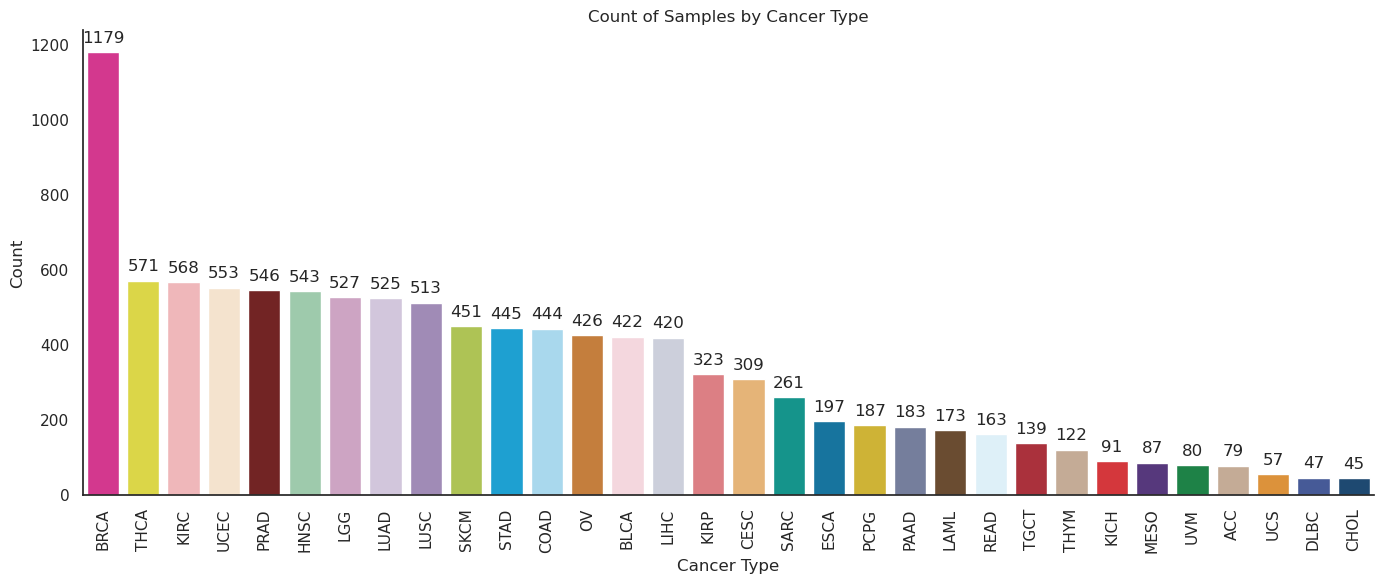

In [13]:
def barplot_dataset(df, savedir='plots', filename=None):
    color_mapping = dict(zip(df['cancer_type'], df['color']))

    primary_site_counts = df['cancer_type'].value_counts().reset_index()
    primary_site_counts.columns = ['cancer_type', 'count']

    sns.set_theme(style="white")
    # Create a bar plot
    plt.figure(figsize=(14, 6))
    barplot = sns.barplot(x='cancer_type', hue='cancer_type', y='count', data=primary_site_counts, palette=color_mapping)
    plt.xlabel('Cancer Type')
    plt.ylabel('Count')
    plt.title('Count of Samples by Cancer Type')
    plt.xticks(rotation=90, ha='center')  # Rotate the x labels to show them more clearly
    
    # Annotate each bar with the count
    for p in barplot.patches:
        barplot.annotate(format(p.get_height(), '.0f'),  # Format the count as a string with no decimal places
                         (p.get_x() + p.get_width() / 2., p.get_height()),  # Position the text at the center of the bar
                         ha='center', va='center',  # Center the text horizontally and vertically
                         xytext=(0, 10),  # Offset the text by 10 points vertically
                         textcoords='offset points')  # Use offset points for the text coordinates
    
    plt.tight_layout()  # Adjust the layout to fit the x labels
    sns.despine()
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

barplot_dataset(tcga_mrna_raw)

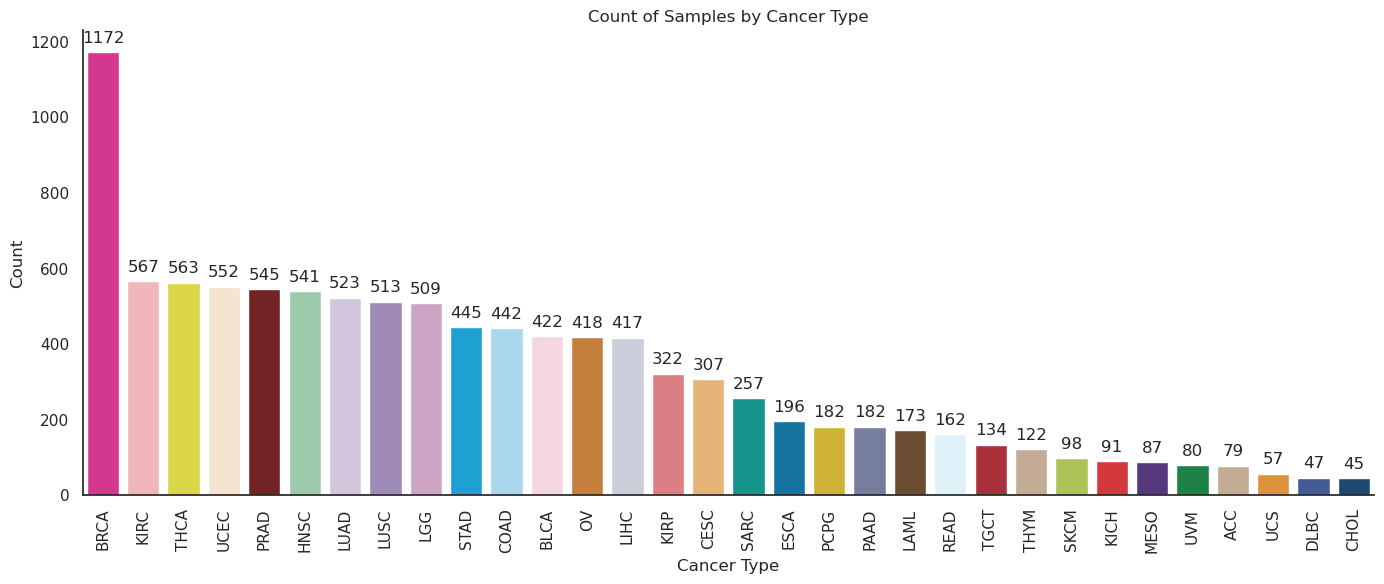

In [14]:
barplot_dataset(tcga_mrna, filename="barplot samples.svg")

## DGD Overview, Training, and Prediction

In drawio ;-)

# Figure 2: Latent space representations and cancer-type clustering

1. representation space PCA
2. GMM clustering heatmap

## Plot Latent Space

In [15]:
def plot_latent_space(rep, means, samples, gmm, labels, color_mapping, title="Train", 
                      savedir="plots", filename=None):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["type"] = "Representation"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="white")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)

    # first plot: representations, means and samples
    sns.scatterplot(data=df, x="PC1", y="PC2", hue="type", size="type", sizes=[10,5,30], 
                    edgecolor = "none", alpha=1, ax=ax[0], palette=["steelblue","orange","black"])
    ax[0].set_title("")
    ax[0].legend(loc='upper left', fontsize='small')
    
    # add explained variance to x-label and y-label for first plot
    ax[0].set_xlabel("")
    ax[0].set_ylabel("")

    # second plot: representations by label
    sns.scatterplot(data=df[df["type"] == "Representation"], x="PC1", y="PC2", hue="label", s=10,
                    edgecolor = "none", alpha=1, ax=ax[1], palette=color_mapping)
    ax[1].set_title("")
    ax[1].legend(loc='center right', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3, fontsize='x-small').remove()
    # Create a combined legend for the second subplot
    
    # add explained variance to x-label and y-label for second plot
    ax[1].set_xlabel("")
    ax[1].set_ylabel("")

    # plot
    plt.suptitle(f'PCA of {title}', fontsize=16)
    fig.supxlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=14)
    fig.supylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=14)
    handles, labels = ax[1].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, -0.02), ncol=8, markerscale=2, fontsize='small')
    # fig.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 0.9), ncol=2, markerscale=3, fontsize='small')

    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

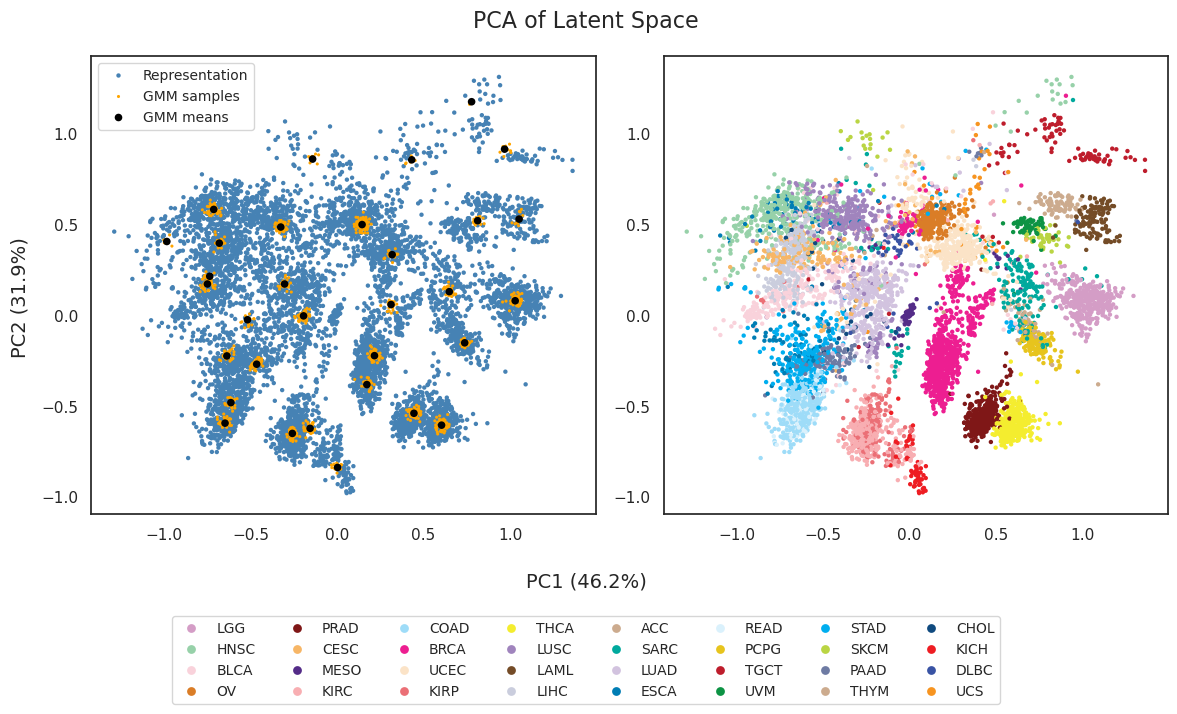

In [16]:
plot_latent_space(*dgd.get_latent_space_values("train",1000), 
                  dgd.gmm, train_loader.dataset.label, 
                  color_mapping, title="Latent Space",
                  filename="latent space pca - train.svg")

## GMM clustering

In [17]:
tissue_mapping = dict(zip(sample_annot['cancer_type'], sample_annot['primary_site']))
tissue_mapping

{'BRCA': 'Breast',
 'LUAD': 'Lung',
 'STAD': 'Stomach',
 'COAD': 'Colorectal',
 'DLBC': 'Lymph Nodes',
 'CHOL': 'Bile Duct',
 'LIHC': 'Liver',
 'PRAD': 'Prostate',
 'KICH': 'Kidney',
 'LAML': 'Bone Marrow',
 'PCPG': 'Adrenal Gland',
 'THYM': 'Thymus',
 'SKCM': 'Skin',
 'SARC': 'Soft Tissue',
 'ACC': 'Adrenal Gland',
 'HNSC': 'Head and Neck',
 'TGCT': 'Testis',
 'PAAD': 'Pancreas',
 'KIRP': 'Kidney',
 'KIRC': 'Kidney',
 'MESO': 'Pleura',
 'THCA': 'Thyroid',
 'LGG': 'Brain',
 'ESCA': 'Esophagus',
 'READ': 'Colorectal',
 'BLCA': 'Bladder',
 'LUSC': 'Lung',
 'UVM': 'Eye',
 'UCS': 'Uterus',
 'UCEC': 'Uterus',
 'CESC': 'Cervix',
 'OV': 'Ovary'}

In [18]:
def gmm_clustering(dgd, rep):
    # if dataset == "train":
    #     rep = dgd.train_rep
    # elif dataset == "val":
    #     rep = dgd.val_rep
    # elif dataset == "test":
    #     rep = dgd.test_rep
        
    clustering = []
    for i in range(len(rep.z)):
        cluster = dgd.to(device).gmm.clustering(rep(i)).unsqueeze(0).detach().cpu().numpy()
        clustering.extend(cluster)
    clustering = np.array(clustering)
    
    return clustering

test_clustering = gmm_clustering(dgd, dgd.test_rep)
train_clustering = gmm_clustering(dgd, dgd.train_rep)

In [19]:
def gmm_clustering_plot(cluster, data_loader, tissue_mapping, is_save=False, savedir="plots", filename=None):
    gmm_comp = pd.DataFrame(
        data={
            'component': cluster,
            'cancer_type': data_loader.dataset.label
        }
    )
    
    # Create dataframe
    df = pd.crosstab(gmm_comp['cancer_type'], gmm_comp['component'])
    df = df.div(df.sum(axis=0))
    df['row_sum'] = df.sum(axis=1)
    df = df.sort_values(by='row_sum', ascending=False)
    df = df.drop(['row_sum'], axis=1)
    
    # Y label
    primary_site_counts = pd.Series(data_loader.dataset.label).value_counts().reset_index()
    primary_site_counts.columns = ['cancer_type', 'count']
    primary_site_counts = primary_site_counts.set_index('cancer_type')
    primary_site_counts = primary_site_counts.loc[df.index]
    primary_site_counts = primary_site_counts.reset_index()
    y_labels = [f"{cancer_type} ({count})" for cancer_type, count in zip(primary_site_counts['cancer_type'], primary_site_counts['count'])]
    
    # X label
    component_counts = pd.Series(cluster).value_counts().sort_index()
    
    # Determine the primary site with the highest count for each component
    primary_site_per_component = df.idxmax(axis=0).map(tissue_mapping)
    
    # x_labels = [f"{primary_site_per_component[component]} ({count})" for component, count in zip(component_counts.index, component_counts.values)]

    # Create x_labels and sort them alphabetically
    x_labels = [f"{primary_site_per_component[component]} ({count})" for component, count in zip(component_counts.index, component_counts.values)]
    x_labels_sorted = sorted(x_labels)
    
    # Create a mapping from sorted labels to original column order
    label_to_col = {label: col for col, label in enumerate(x_labels)}
    new_col_order = [label_to_col[label] for label in x_labels_sorted]
    
    # Reorder the dataframe columns
    df = df.iloc[:, new_col_order]
    '''
    # Create a heatmap using seaborn
    sns.set_style(style="white")
    plt.subplots(figsize=(16, 10))
    annot = df.map(lambda x: f'{x:.2f}' if x >= 1e-2 else '')
    cmap = mpl.colormaps.get_cmap('Blues')
    cmap.set_bad("white")
    g = sns.heatmap(df, annot=annot, mask=False, cmap=cmap, fmt='', linewidth=0.7, annot_kws={'size': 9.5},
                    cbar_kws={'shrink': 0.8, 'label': 'Sample Proportion per Component', 'pad': 0.01})
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    plt.xlabel("GMM components (#samples)", fontsize=12)
    plt.ylabel("Cancer Type (#samples)", fontsize=12)
    g.set_xticklabels(x_labels, fontsize=11, rotation=90)
    g.set_yticklabels(y_labels, fontsize=10.5)
    plt.tight_layout()
    plt.title("GMM Clustering", fontsize=16)
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()
    '''
    # Create a heatmap using seaborn
    sns.set_style(style="white")
    plt.subplots(figsize=(16, 10))
    annot = df.map(lambda x: f'{x:.2f}' if x >= 1e-2 else '')
    cmap = mpl.colormaps.get_cmap('Blues')
    cmap.set_bad("white")
    g = sns.heatmap(df, annot=annot, mask=False, cmap=cmap, fmt='', linewidth=0.7, annot_kws={'size': 9.5},
                    cbar_kws={'shrink': 0.8, 'label': 'Sample Proportion per Component', 'pad': 0.01})
    g.set_yticklabels(g.get_yticklabels(), rotation=0)
    plt.xlabel("GMM components (#samples)", fontsize=12)
    plt.ylabel("Cancer Type (#samples)", fontsize=12)
    g.set_xticklabels(x_labels_sorted, fontsize=11, rotation=90)
    g.set_yticklabels(y_labels, fontsize=10.5)
    plt.tight_layout()
    plt.title("GMM Clustering", fontsize=16)
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

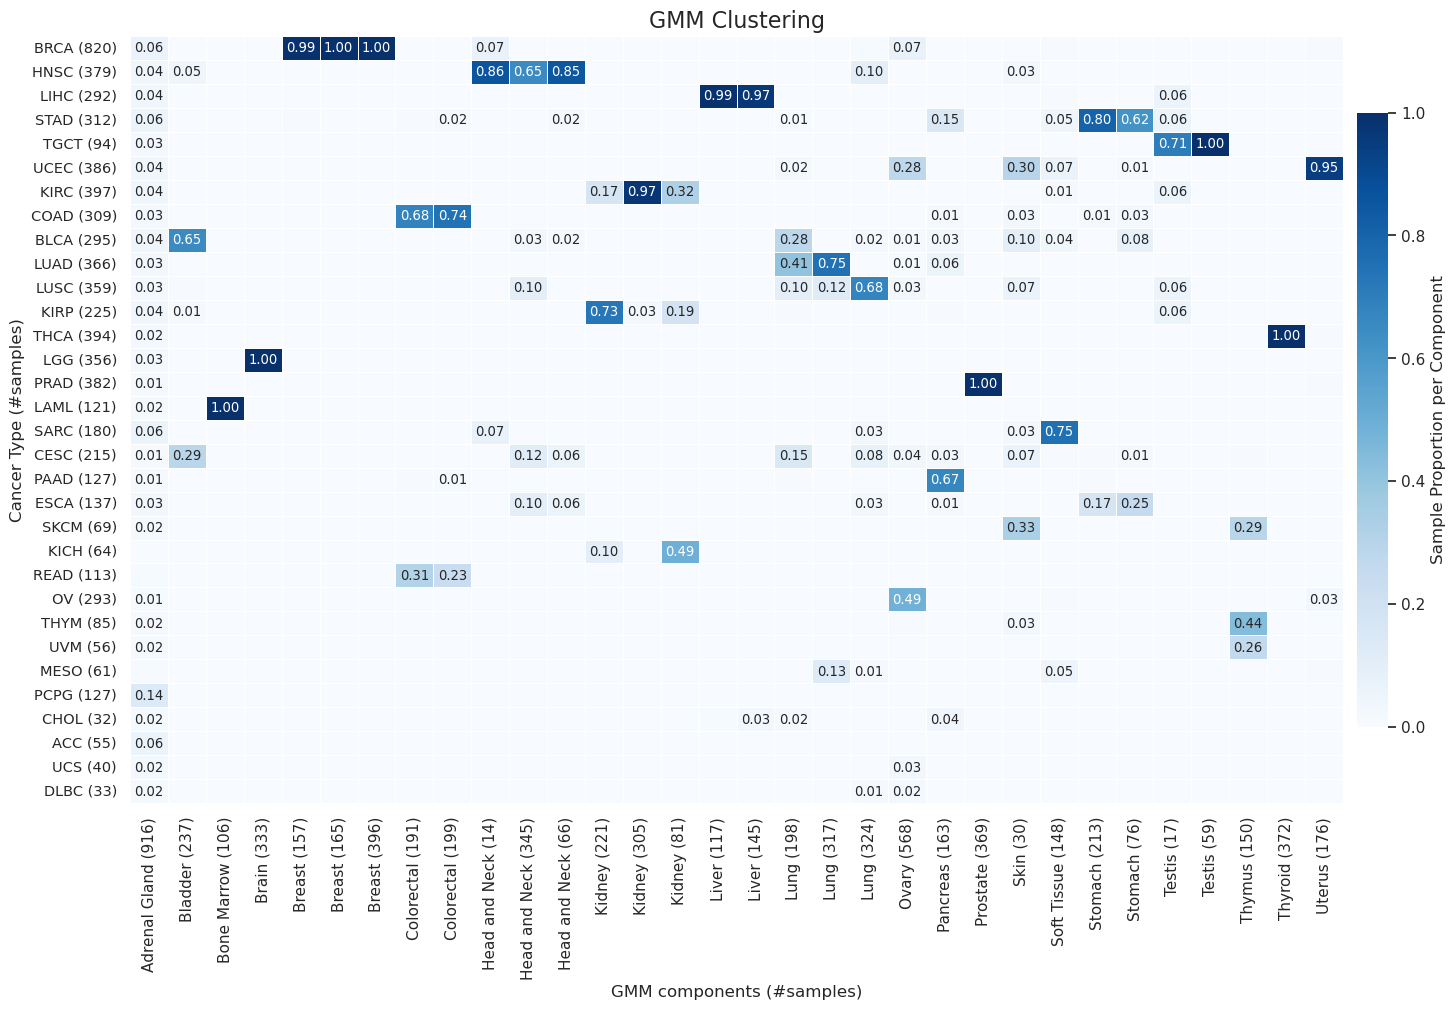

In [20]:
gmm_clustering_plot(train_clustering, train_loader, tissue_mapping, filename="gmm clustering train data.svg")

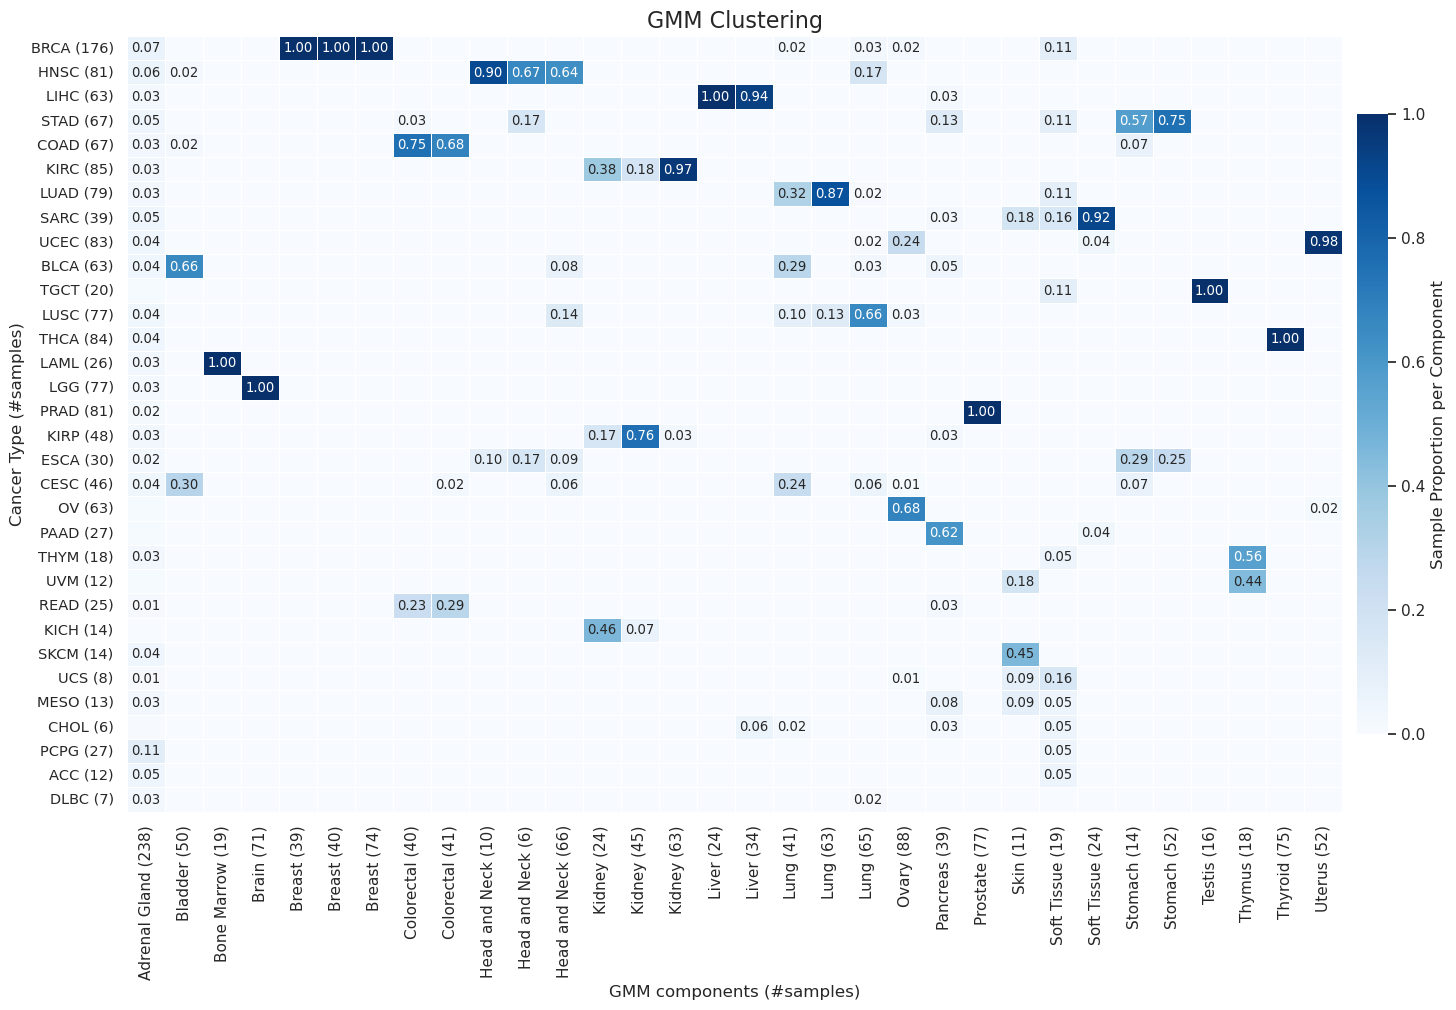

In [21]:
gmm_clustering_plot(test_clustering, test_loader, tissue_mapping, filename="gmm clustering test data.svg")

### calculate rand index

In [22]:
from sklearn.metrics.cluster import rand_score, adjusted_rand_score

def calculate_rand(dgd_rep, data_loader):
    labels = data_loader.dataset.label
    clustering = []
    
    df = pd.DataFrame(labels, columns=["label"])
    
    rep = dgd_rep
    for i in range(len(rep.z)):
        cluster = dgd.gmm.clustering(rep(i)).unsqueeze(0).detach().cpu().numpy()
        clustering.extend(cluster)
    df["cluster"] = clustering
    df["cluster"] = df["cluster"].astype('category')

    label_counts = df.groupby(['cluster', 'label'], observed=False).size().reset_index(name='counts')
    most_frequent_labels = label_counts.loc[label_counts.groupby('cluster', observed=False)['counts'].idxmax()]
    cluster_to_label = dict(zip(most_frequent_labels['cluster'], most_frequent_labels['label']))
    df['cluster_name'] = df['cluster'].map(cluster_to_label)

    rand_index = adjusted_rand_score(df["label"], df["cluster_name"])

    return rand_index

In [23]:
print(calculate_rand(dgd.train_rep, train_loader))

0.575979037439599


In [24]:
print(calculate_rand(dgd.test_rep, test_loader))

0.5387076762087756


# Figure 3: Prediction of miRNA expression levels (examples and overall performance)

1. average correlation of expression level prediction
2. miR-example regression plot of all samples
3. miR-example regression plot tissue-specific
4. miR-example scatter plot per cancer type

## average correlation

In [25]:
def calculate_corr(X, y, axis=0):
    spearman_corr = []
    pearson_corr = []
    spearman_pval = []
    pearson_pval = []
    r2 = []
    r2_pval = []
    X = X.iloc[:,:-4]
    y = y.iloc[:,:-4]
    
    if axis == 0:
        for i in range(y.shape[1]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[:, i], y.iloc[:, i])
            pearson, pearson_p = stats.pearsonr(X.iloc[:, i], y.iloc[:, i])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[:, i], y.iloc[:, i])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.columns
            },
            index=np.arange(0, len(X.columns))
        )
    elif axis == 1:
        for i in range(y.shape[0]):
            # Calculate Spearman correlation coefficient
            spearman, spearman_p = stats.spearmanr(X.iloc[i, :], y.iloc[i, :])
            pearson, pearson_p = stats.pearsonr(X.iloc[i, :], y.iloc[i, :])
            _, _, r_value, r_p, _ = stats.linregress(X.iloc[i, :], y.iloc[i, :])
            
            spearman_corr.append(spearman)
            pearson_corr.append(pearson)
            r2.append(r_value**2)
            spearman_pval.append(spearman_p)
            pearson_pval.append(pearson_p)
            r2_pval.append(r_p)
        
        corr_data = pd.DataFrame(
            data={  
                'pearson': pearson_corr,
                'spearman': spearman_corr,
                'r2': r2,
                'pearson_p': pearson_pval,
                'spearman_p': spearman_pval,
                'r2_p': r2_pval,
                'mirna': X.index[:-4]
            },
            index=np.arange(0, len(X.index))
        )
    else:
        raise ValueError("Axis must be 0 (columns) or 1 (rows).")
    
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_pearson(X, y, sparsity):
    pearson_corr = []
    pearson_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        pearson, pearson_p = stats.pearsonr(X.iloc[:,i], y.iloc[:,i])
        pearson_corr.append(pearson)
        pearson_pval.append(pearson_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'pearson': pearson_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='pearson', ascending=False, ignore_index=True)

def calculate_spearman(X, y, sparsity):
    spearman_corr = []
    spearman_pval = []
    
    for i in range(y_test.shape[1]-4):
        # Calculate Spearman correlation coefficient
        spearman, spearman_p = stats.spearmanr(X.iloc[:,i], y.iloc[:,i])
        spearman_corr.append(spearman)
        spearman_pval.append(spearman_p)
        
    corr_data = pd.DataFrame(
        data={  
            'mirna': X.columns[:-4],
            'spearman': spearman_corr,
            'sparsity': np.repeat(sparsity, len(X.columns[:-4]))
        },
        index=np.arange(0, len(X.columns[:-4]))
    )
    return corr_data.sort_values(by='spearman', ascending=False, ignore_index=True)

In [26]:
def plot_average_correlation(savedir='plots', filename='None'):
    sns.set_theme(style="whitegrid")
    sns.set_style("white")
    fig = plt.figure(figsize=(8,3))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=corr_data, x='spearman', bins=30)
    # plt.title("Spearman's Correlation")
    plt.xlabel("Spearman's Correlation")
    mean_spearman = corr_data['spearman'].mean()
    plt.axvline(mean_spearman, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_spearman, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_spearman:.2f}', color='red')
    
    plt.subplot(1,2,2)
    sns.histplot(data=corr_data, x='pearson', bins=30)
    # plt.title("Pearson's Correlation")
    plt.xlabel("Pearson's Correlation")
    plt.ylabel("")
    mean_pearson = corr_data['pearson'].mean()
    plt.axvline(mean_pearson, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_pearson, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_pearson:.2f}', color='red')
    
    # Add the main title to the figure
    # fig.suptitle("samples correlation histogram", fontsize=16)
    
    # Display the plots
    sns.despine()
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename))
    plt.show()

In [27]:
corr_data = calculate_corr(X_test, y_test, axis=0)

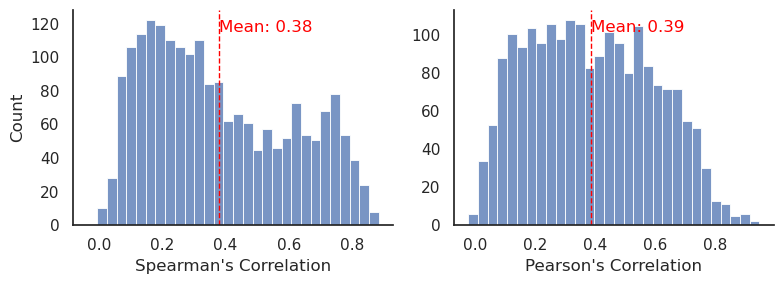

In [28]:
plot_average_correlation(corr_data, filename=None)

## regression

In [29]:
def regression_plot(subset, cancer_type=None, savedir="plots", filename=None):
    test = get_mirna_data(dgd, data_loader, subset=subset, dataset="test")

    if cancer_type:
        test = test[test['cancer_type'] == cancer_type]
    
    # Set the aesthetic style of the plots
    sns.set_style("white")
    
    # Create a figure to hold the subplots
    plt.figure(figsize=(4, 4))
    # plt.subplots_adjust(vspace=0.1)
    
    # Create scatterplot
    sns.regplot(data=test, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    sns.despine()
    # Calculate Spearman correlation coefficient
    spearman_corr, spearman_p = stats.spearmanr(test['X'], test['y'])
    pearson_corr, pearson_p = stats.pearsonr(test['X'], test['y'])
    # Add correlation coefficient as text annotation
    if spearman_p < 2.2e-10:
        plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = <2.2e-10", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    else:
        plt.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = {spearman_p:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    if pearson_p < 2.2e-10:
        plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = <2.2e-10", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    else:
        plt.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = {pearson_p:.2f}", transform=plt.gca().transAxes, fontsize=10, verticalalignment='top')
    
    plt.xlabel("Predicted expression", fontsize=11)
    plt.ylabel("True expression", fontsize=11)
    plt.xticks(fontsize=9)
    plt.yticks(fontsize=10)

    # Add a small dashed diagonal line
    min_val = min(test['X'].min(), test['y'].min())
    max_val = max(test['X'].max(), test['y'].max())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle='dashed', linewidth=0.5, color='black')
    
    if cancer_type:
        plt.title(f"{subset} in {cancer_type}", fontsize=12, y=1)
    else:
        plt.title(f"{subset} expression", fontsize=12, y=1)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

In [75]:
mir = 'hsa-miR-9-3p'
cancer = 'LGG'

## miRNA regression plot all samples

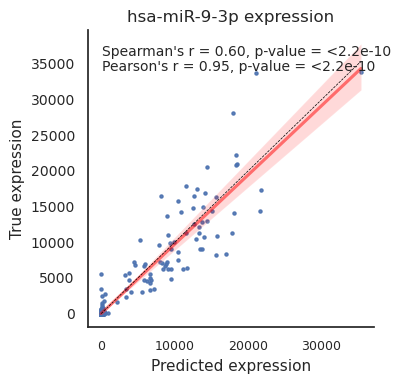

In [76]:
regression_plot(mir, filename=f"regplot {mir}.svg")

## miRNA regression plot tissue-specific

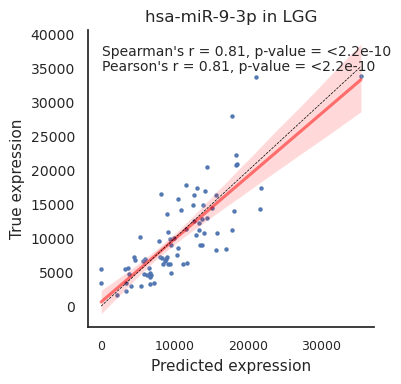

In [77]:
regression_plot(mir, cancer, filename=f"regplot {mir} in {cancer}.svg")

## miRNA scatter plot per cancer type

In [33]:
def plot_jitter_grouped_tissue(subset, savedir="plots", filename=None):
    data = get_mirna_data(dgd, data_loader, subset=subset)

    # Calculate RMSE
    rmse = root_mean_squared_error(data['y'], data['X'])
    
    sns.set_style("white")
    fig, axes = plt.subplots(2, 1, figsize=(10, 6), sharey=True)
    plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
    sns.boxplot(data=data, x="cancer_type", y="y", hue="tissue", boxprops=dict(alpha=.3), showfliers=False, ax=axes[0])
    sns.stripplot(data=data, x="cancer_type", y="y", hue="tissue", alpha=0.8, zorder=0, ax=axes[0])
    axes[0].set_title("")
    axes[0].set_xlabel("")
    axes[0].set_ylabel("True expression", fontsize=12)
    axes[0].set_xticks([])
    axes[0].tick_params(axis='y', labelsize=10)
    axes[0].legend(fontsize=8)

    # Annotate RMSE
    axes[0].text(0.01, 0.95, f'RMSE: {rmse:.2f}', 
                 horizontalalignment='left', 
                 verticalalignment='top', 
                 transform=axes[0].transAxes, 
                 fontsize=12, 
                 bbox=dict(facecolor='white', alpha=0.5))
    
    sns.boxplot(data=data, x="cancer_type", y="X", hue="tissue", boxprops=dict(alpha=.3), showfliers=False, ax=axes[1])
    sns.stripplot(data=data, x="cancer_type", y="X", hue="tissue", alpha=0.9, zorder=0, ax=axes[1])
    axes[1].set_title("")
    axes[1].set_xlabel("Cancer Type", fontsize=12)
    axes[1].set_ylabel("Predicted expression", fontsize=12)
    axes[1].tick_params(axis='x', rotation=90, labelsize=12)
    axes[1].tick_params(axis='y', labelsize=10)
    axes[1].legend(fontsize=8).remove()

    # Ensure x-tick labels are colored correctly
    for ax in axes:
        labels = ax.get_xticklabels()
        for label, cancer_type in zip(labels, data['cancer_type'].unique()):
            label.set_fontweight('normal')
            label.set_color(palette[cancer_type])
            
    fig.suptitle(f"{subset} expression", fontsize=14, y=0.95)
    sns.despine(bottom=False)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

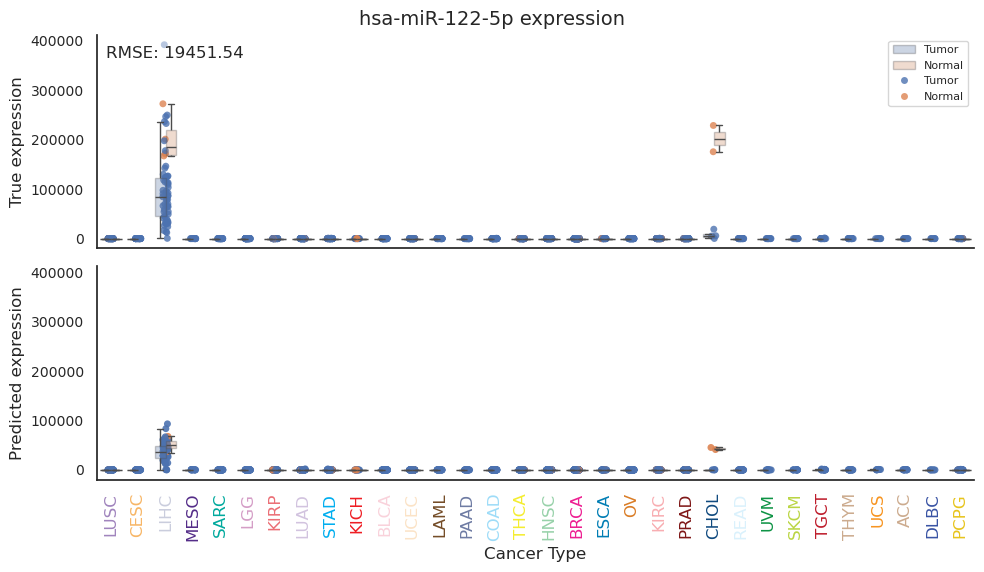

In [34]:
plot_jitter_grouped_tissue(mir, filename=f"jitter {mir}.svg")

# Figure 4: Downsampled (to mimic scRNA-seq) and actual scRNA-seq



1. downsampled regression plot miR-example
2. top correlating miRNA in various downsampled data

## prepare downsampled data

mnt_path = '/home/farzamani/'
project_path = os.path.join(mnt_path, "jsp_student_projects/miRNA_DGD_Farhad_F2024/")
midgd_path = os.path.join(project_path, "miDGD")
data_path = os.path.join(midgd_path, "data/downsampled/")

sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

mrna_sparse = []
sparse_mrna_test = []

for i, sp in enumerate(sparsity):
    datapath = os.path.join(data_path, f"TCGA_mrna_downsampled_{sp}.tsv")
    print(datapath)
    mrna = pd.read_csv(datapath, sep="\t", index_col=[0])
    mrna_sparse.append(mrna)
    
    mrna_sparse[i] = mrna_sparse[i].reindex(index=tcga_mrna.index, columns=tcga_mrna.columns)
    sparse_mrna_test.append(mrna_sparse[i].loc[test_idx])

sparsity = ["1000", "5000", "10000", "50000", "1e+05", "5e+05", "1e+06", "5e+06", "1e+07"]

test_datasets = []
test_loaders = []
test_rep_sparse = []
batch_size = 128

for i, sp in enumerate(sparsity):
    # Train, val, and test data loaders
    dataset = GeneExpressionDatasetCombined(sparse_mrna_test[i], test_mirna, scaling_type='mean')
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size, 
                                         shuffle=False,
                                         num_workers=num_workers)
    test_datasets.append(dataset)
    test_loaders.append(loader)

    test_rep = learn_new_representation(dgd, loader, learning_rates=1e-2, weight_decay=1e-4, test_epochs=30)
    test_rep_sparse.append(test_rep)

torch.save(test_rep_sparse, "results/test_rep_ms.pt")
torch.save(test_loaders, "results/test_loaders_ms.pt")
print("Done!")

In [93]:
test_rep_load = torch.load("results/test_rep_ms.pt")
test_loaders = torch.load("results/test_loaders_ms.pt")

### pca as sanity check

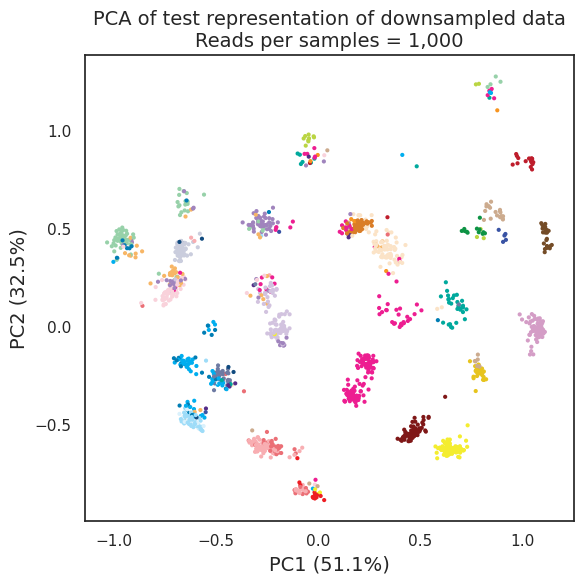

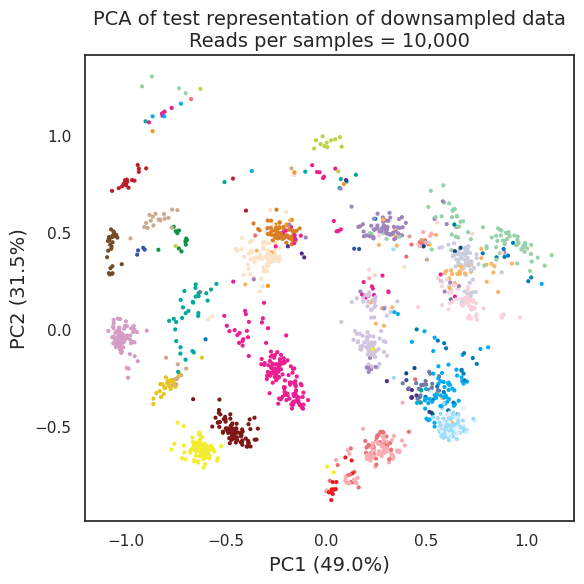

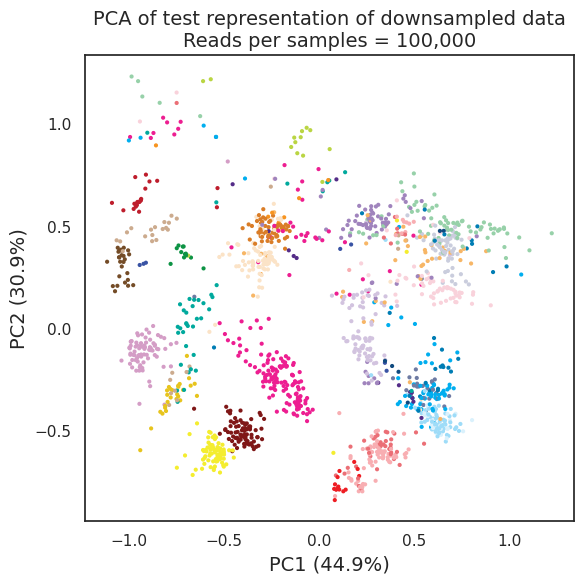

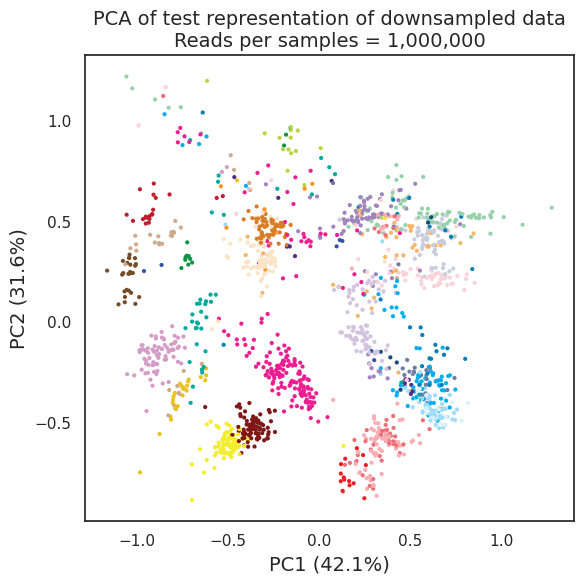

In [94]:
def plot_latent_space_sparse(rep, means, samples, gmm, labels, color_mapping, title="Train", 
                      savedir="plots", filename=None):
    # get PCA
    pca = PCA(n_components=2)
    pca.fit(rep)
    rep_pca = pca.transform(rep)
    means_pca = pca.transform(means)
    samples_pca = pca.transform(samples)
    df = pd.DataFrame(rep_pca, columns=["PC1", "PC2"])
    df["type"] = "Representation"
    df["label"] = labels
    df_temp = pd.DataFrame(samples_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM samples"
    df = pd.concat([df,df_temp])
    df_temp = pd.DataFrame(means_pca, columns=["PC1", "PC2"])
    df_temp["type"] = "GMM means"
    df = pd.concat([df,df_temp])

    # make a figure with 2 subplots
    # set a small text size for figures
    plt.rcParams.update({'font.size': 6})
    sns.set_theme(style="white")
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    # add spacing between subplots
    fig.subplots_adjust(wspace=0.2, top=0.9)

    # second plot: representations by label
    sns.scatterplot(data=df[df["type"] == "Representation"], x="PC1", y="PC2", hue="label", s=9,
                    edgecolor = "none", alpha=1, ax=ax, palette=color_mapping)
    ax.set_title("")
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3, fontsize='x-small').remove()
    # Create a combined legend for the second subplot
    
    # add explained variance to x-label and y-label for second plot
    ax.set_xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=14)
    ax.set_ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=14)
    ax.set_title(f'{title}', fontsize=14)
    # ax.set_subtitle(f'{title}', fontsize=14)

    # plot
    # plt.suptitle(f'{title}', fontsize=16)
    # fig.supxlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)", fontsize=14)
    # fig.supylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)", fontsize=14)
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1, 0.5), ncol=2, markerscale=3, fontsize='medium').remove()

    plt.tight_layout()
    
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

sparsity = ["1,000", "5,000", "10,000", "50,000", "100,000", "500,000", "1,000,000", "5,000,000", "10,000,000"]

include = ["1,000", "10,000", "100,000", "1,000,000"]

for i, sp in enumerate(sparsity):
    if sp not in include:
        continue
    plot_latent_space_sparse(test_rep_load[i].z.clone().detach().cpu().numpy(), 
                      dgd.gmm.mean.clone().detach().cpu().numpy(), 
                      dgd.gmm.sample(3000).detach().cpu().numpy(), 
                      dgd.gmm, 
                      test_loaders[i].dataset.label, color_mapping, title=f"PCA of test representation of downsampled data\nReads per samples = {sp}",
                      filename=f"pca-test-rep-sparsity-{sp}.svg")

## top correlating miRNA

In [95]:
corr_data_spearman = calculate_spearman(X_test, y_test, "Bulk")
corr_data_pearson = calculate_pearson(X_test, y_test, "Bulk")

top_mirna_spearman = corr_data_spearman.head(50)
top_mirna_pearson = corr_data_pearson.head(50)

def top_sparse(top_mirna_spearman, top_mirna_pearson):
    sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]
    
    for i, sp in enumerate(sparsity):
        X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
        
        corr = calculate_spearman(X, y, sp)
        mask = corr['mirna'].isin(top_mirna_spearman['mirna'])
        corr_filtered = corr[mask]
        top_mirna_spearman = pd.concat([top_mirna_spearman, corr_filtered])

        corr = calculate_pearson(X, y, sp)
        mask = corr['mirna'].isin(top_mirna_pearson['mirna'])
        corr_filtered = corr[mask]
        top_mirna_pearson = pd.concat([top_mirna_pearson, corr_filtered])

    return top_mirna_spearman, top_mirna_pearson
    
spearman_mirna, pearson_mirna = top_sparse(top_mirna_spearman, top_mirna_pearson)

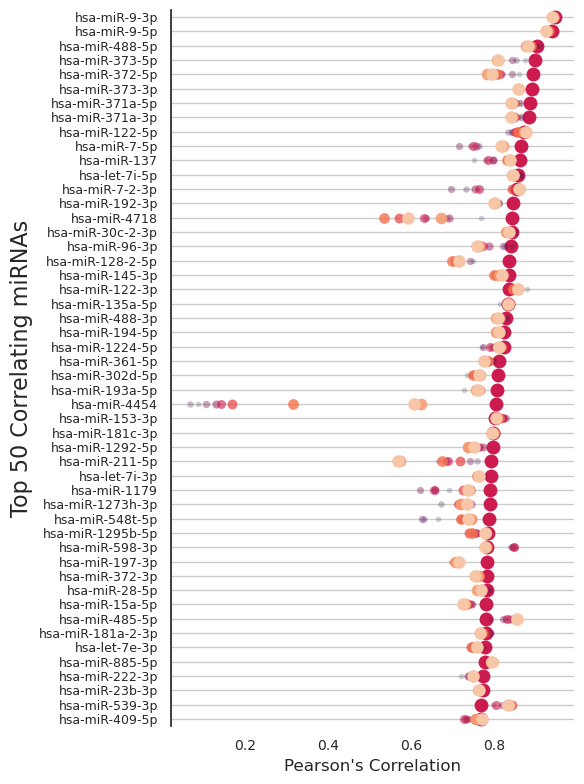

In [96]:
def plot_stripplot_corr_pearson(pearson_mirna, savedir="plots", filename=None):
    # Define the sparsity values
    sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]
    
    # Set the color palette
    palette = sns.color_palette("rocket", n_colors=len(sparsity))
    sns.set_style("white")
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # Plot the "Bulk" sparsity data
    sns.stripplot(x="pearson", y="mirna", hue="sparsity", data=pearson_mirna[pearson_mirna["sparsity"] == "Bulk"],
                  size=10, alpha=1.0, palette="rocket", ax=ax, dodge=True, legend=False)
    
    # Plot the stripplot for other sparsity values
    for i, sp in enumerate(sparsity):
        # Calculate the size and alpha based on the sparsity value
        size = 4 + (i / (len(sparsity) - 1)) * 5  # Increase size from 3 to 10
        alpha = 0.2 + (i / (len(sparsity) - 1)) * 0.8  # Increase alpha from 0.2 to 1.0
        
        # Plot the data for the current sparsity value
        sns.stripplot(x="pearson", y="mirna", hue="sparsity", data=pearson_mirna[pearson_mirna["sparsity"] == sp],
                      size=size, alpha=alpha, palette=[palette[i]], ax=ax, dodge=True, legend=False)
    
    # Add horizontal grid lines
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    
    # Create custom legend handles for sizes
    size_handles = [plt.Line2D([], [], marker='o', color=palette[i], markersize=4 + (i / (len(sparsity) - 1)) * 5, alpha=0.2 + (i / (len(sparsity) - 1)) * 0.8, label=sp) for i, sp in enumerate(sparsity)]
    bulk_handle = plt.Line2D([], [], marker='o', color=palette[4], markersize=10, alpha=1.0, label='Bulk')
    
    # Combine all handles
    all_handles = size_handles + [bulk_handle]
    
    # Add combined legend
    ax.legend(handles=all_handles, title="Sparsity", loc="upper left", bbox_to_anchor=(1.01, 1), ncol=1, fontsize='10').set_visible(False)
    
    # Adjust plot layout
    plt.subplots_adjust(right=0.8)
    sns.despine(bottom=True)
    plt.xlabel("Pearson's Correlation", fontsize=12)
    plt.ylabel("Top 50 Correlating miRNAs", fontsize=16)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

plot_stripplot_corr_pearson(pearson_mirna, filename="top 50 pearson sparse.svg")

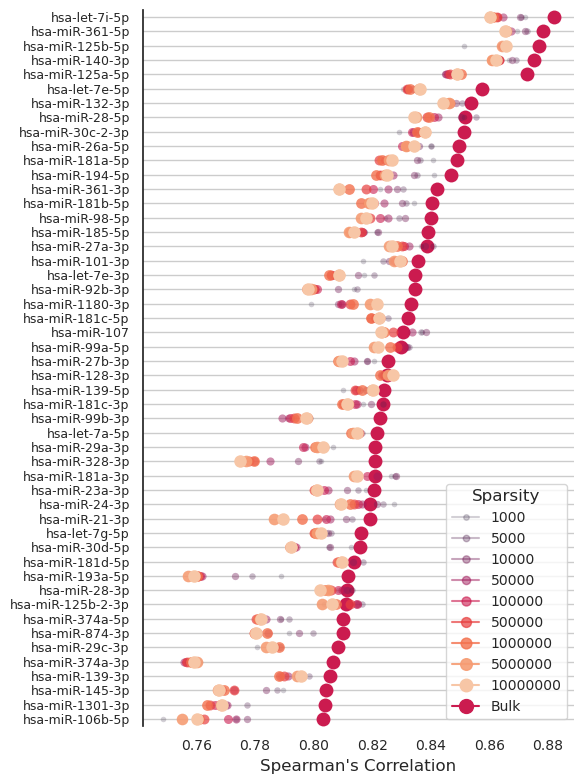

In [97]:
def plot_stripplot_corr_spearman(spearman_mirna, savedir="plots", filename=None):
    # Define the sparsity values
    sparsity = ["1000", "5000", "10000", "50000", "100000", "500000", "1000000", "5000000", "10000000"]
    
    # Set the color palette
    palette = sns.color_palette("rocket", n_colors=len(sparsity))
    sns.set_style("white")
    
    # Create the figure and axes
    fig, ax = plt.subplots(figsize=(6, 8))
    
    # Plot the "Bulk" sparsity data
    sns.stripplot(x="spearman", y="mirna", hue="sparsity", data=spearman_mirna[spearman_mirna["sparsity"] == "Bulk"],
                  size=10, alpha=1.0, palette="rocket", ax=ax, dodge=True, legend=False)
    
    # Plot the stripplot for other sparsity values
    for i, sp in enumerate(sparsity):
        # Calculate the size and alpha based on the sparsity value
        size = 4 + (i / (len(sparsity) - 1)) * 5  # Increase size from 3 to 10
        alpha = 0.2 + (i / (len(sparsity) - 1)) * 0.8  # Increase alpha from 0.2 to 1.0
        
        # Plot the data for the current sparsity value
        sns.stripplot(x="spearman", y="mirna", hue="sparsity", data=spearman_mirna[spearman_mirna["sparsity"] == sp],
                      size=size, alpha=alpha, palette=[palette[i]], ax=ax, dodge=True, legend=False)
    
    # Add horizontal grid lines
    ax.yaxis.grid(True)
    ax.xaxis.grid(False)
    
    # Create custom legend handles for sizes
    size_handles = [plt.Line2D([], [], marker='o', color=palette[i], markersize=4 + (i / (len(sparsity) - 1)) * 5, alpha=0.2 + (i / (len(sparsity) - 1)) * 0.8, label=sp) for i, sp in enumerate(sparsity)]
    bulk_handle = plt.Line2D([], [], marker='o', color=palette[4], markersize=10, alpha=1.0, label='Bulk')
    
    # Combine all handles
    all_handles = size_handles + [bulk_handle]
    
    # Add combined legend
    ax.legend(handles=all_handles, title="Sparsity", loc="lower right", ncol=1, fontsize='10')
    
    # Adjust plot layout
    plt.subplots_adjust(right=0.8)
    sns.despine(bottom=True)
    plt.xlabel("Spearman's Correlation", fontsize=12)
    plt.ylabel("Top 50 Correlating miRNAs", fontsize=16).set_visible(False)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=9)
    plt.tight_layout()
    if filename is not None:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight')
    plt.show()

plot_stripplot_corr_spearman(spearman_mirna, filename="top 50 spearman sparse.svg")

## regression plot across downsampled

In [98]:
sparsity = ["1,000", "5,000", "10,000", "50,000", "100,000", "500,000", "1,000,000", "5,000,000", "10,000,000"]
exclude = True
if exclude:
    # exclude = ["5,000", "10,000", "50,000", "500,000", "1,000,000", "5,000,000"]
    # exclude = ["5,000", "10,000", "50,000", "500,000", "1,000,000", "5,000,000", "10,000,000"]
    exclude = ["1,000", "5,000", "50,000", "500,000", "5,000,000", "10,000,000"]
else:
    exclude = []
    
def regplot_sparsity(dgd, test_rep_load, test_loader, mirna_column, subset, cancer_type=None, savedir="plots", filename=None):
    # Create an empty DataFrame to hold all data
    all_data = pd.DataFrame()
    
    for i, sp in enumerate(sparsity):
        if sp in exclude:
            continue
        X, y = _get_data_pred_from_rep(dgd, test_rep_load[i], test_loader, mirna_column)
        df = pd.DataFrame(
                    data={
                        'X': X.loc[:,subset], 
                        'y': y.loc[:,subset],
                        'cancer_type': X.loc[:,'cancer_type'],
                        'tissue': X.loc[:,'tissue'],
                        'color': X.loc[:,'color'],
                        'sparsity': sp  # Add sparsity as a column
                    }
                )
        all_data = pd.concat([all_data, df], ignore_index=True)

    if cancer_type:
        all_data = all_data[all_data['cancer_type'] == cancer_type]
    
    # Set the aesthetic style of the plots
    sns.set_style("white")
    
    # Create a FacetGrid
    g = sns.FacetGrid(all_data, col="sparsity", col_wrap=3, height=4, aspect=0.9)
    g.map_dataframe(sns.regplot, x="X", y="y", scatter_kws={"s": 5, "alpha": .9}, line_kws={"color": "red", "alpha": .5})
    
    # Add correlation coefficients and diagonal line to each facet
    for ax, (name, group) in zip(g.axes.flat, all_data.groupby("sparsity")):
        spearman_corr, spearman_p = stats.spearmanr(group['X'], group['y'])
        pearson_corr, pearson_p = stats.pearsonr(group['X'], group['y'])
        if spearman_p > 2.2e-10:
            ax.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = {spearman_p:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        else:
            ax.text(0.05, 0.95, f"Spearman's r = {spearman_corr:.2f}, p-value = <2.2e-10", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        if pearson_p > 2.2e-10:
            ax.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = {pearson_p:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        else:
            ax.text(0.05, 0.90, f"Pearson's r = {pearson_corr:.2f}, p-value = <2.2e-10", transform=ax.transAxes, fontsize=10, verticalalignment='top')
        # Add a diagonal line x=y
        min_val = min(group['X'].min(), group['y'].min())
        max_val = max(group['X'].max(), group['y'].max())
        ax.plot([min_val, max_val], [min_val, max_val], linestyle='dashed', linewidth=0.5, color='black')
        
        # Decrease the size of the ticks and labels
        ax.tick_params(axis='x', labelsize=10)
        ax.tick_params(axis='y', labelsize=10)
        # ax.tick_params(axis='both', which='minor', labelsize=8, rotation=45)
    
    g.set_axis_labels("Predicted expression", "True expression")
    g.set_titles(col_template="reads per sample = {col_name}", size=12)
    
    g.set_xlabels(fontsize=11)
    g.set_ylabels(fontsize=11)
    if cancer_type:
        plt.suptitle(f"{subset} in {cancer_type}", size=16)
    else:
        plt.suptitle(f"{subset}", size=16)
    plt.tight_layout()
    if filename:
        plt.savefig(os.path.join(savedir, filename), bbox_inches='tight', dpi=300)
    plt.show()

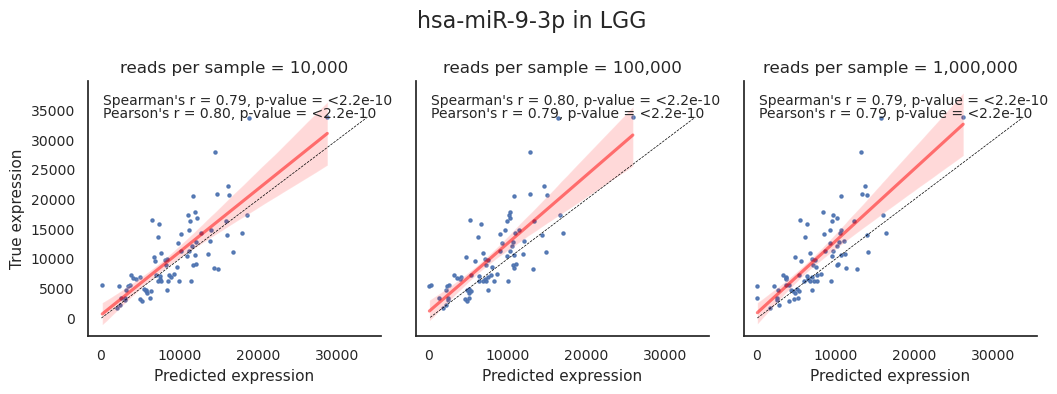

In [100]:
regplot_sparsity(dgd, test_rep_load, test_loader, mirna_column, mir, cancer_type=cancer, filename=f"regplot_facet {mir}.svg")

# Figure 5: Treating individual mRNA/miRNAs as missing and regulatory network inference

1. Show if miR-122-5p is perturbed, the target mRNA will also perturbed


In [176]:
genes = tcga_mrna.columns[:-4]

In [180]:
from biomart import BiomartServer

def query_biomart(ensembl_ids, batch_size=100):
    server = BiomartServer("http://www.ensembl.org/biomart")
    ensembl = server.datasets["hsapiens_gene_ensembl"]
    
    attributes = ["ensembl_gene_id", "external_gene_name"]
    ensembl_to_symbol = {}
    
    for i in range(0, len(ensembl_ids), batch_size):
        print(i)
        batch = ensembl_ids[i:i+batch_size]
        filters = {"ensembl_gene_id": batch}
        
        response = ensembl.search({"attributes": attributes, "filters": filters})
        
        for line in response.iter_lines():
            line = line.decode('utf-8')
            if line:
                ens_id, symbol = line.split('\t')
                ensembl_to_symbol[ens_id] = symbol if symbol else ens_id
    return ensembl_to_symbol

# Extract Ensembl IDs (removing version numbers)
ensembl_ids = [gene.split('.')[0] for gene in genes]

# Query BioMart in batches
ensembl_to_symbol = query_biomart(ensembl_ids)

# Convert the gene IDs to symbols
gene_symbols = [ensembl_to_symbol.get(gene.split('.')[0], gene) for gene in genes]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
18

In [212]:
column_index = gene_symbols.index('FOXG1')
test_loader.dataset.mrna_data[:, column_index].sum()

tensor(0.)

In [ ]:
test_loader.dataset.mrna_data

In [1]:
perturbed_data = []
fold_change = [1e-2, 1e-1, 1e-0, 1e1, 1e2]

for i, fc in enumerate(fold_change):
    original_tensor = test_loader.dataset.mrna_data
    original_tensor[:, column_index] = original_tensor[:, column_index] * fc
    perturbed_data.append(fc)

#perturbed_data[1][:, column_index]
perturbed_data

[0.01, 0.1, 1.0, 10.0, 100.0]

## prepare data

# Supplementary: missing data

In [136]:
original_tensor = test_loader.dataset.mrna_data
column_to_modify = 0

num_rows_to_replace = int(0.1 * original_tensor.shape[0])

random_indices = torch.randperm(original_tensor.shape[0])[:num_rows_to_replace]

new_tensor = original_tensor.clone()
new_tensor[random_indices, column_to_modify] = float('nan')

In [137]:
new_tensor.isnan().sum()

tensor(153)